In [25]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import copy

data_dir = 'C:/ZhangLI/Codes/DataSet/个人违贷/official_data/'
train_pub = pd.read_csv(data_dir+'train_public.csv')
train_net = pd.read_csv(data_dir+'train_internet.csv')
test_pub = pd.read_csv(data_dir+'test_public.csv')

In [3]:
def preprocessor(dataframe):
    dataframe['issue_date'] = pd.to_datetime(dataframe['issue_date'])
    dataframe['issue_date_y'] = dataframe['issue_date'].dt.year
    dataframe['issue_date_m'] = dataframe['issue_date'].dt.month

    # set origin date
    # get the diff bewteen now and origin-date
    origin_date = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    dataframe['issue_date_diff'] = dataframe['issue_date'].apply(lambda x: x-origin_date).dt.days
    dataframe.drop('issue_date', axis = 1, inplace = True)
    
    # 就业类型
    employer_type = dataframe['employer_type'].value_counts().index
    industry = dataframe['industry'].value_counts().index
    emp_type_dict = dict(zip(employer_type, [0,1,2,3,4,5]))
    industry_dict = dict(zip(industry, [i for i in range(15)]))
    # 
    dataframe['work_year'].fillna('10+ years', inplace=True)

    work_year_map = {'10+ years': 10, '2 years': 2, '< 1 year': 0, '3 years': 3, '1 year': 1,
         '5 years': 5, '4 years': 4, '6 years': 6, '8 years': 8, '7 years': 7, '9 years': 9}
    dataframe['work_year']  = dataframe['work_year'].map(work_year_map)

    dataframe['class'] = dataframe['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

    emp_type_dict = {'政府机构': 1, '幼教与中小学校': 2, '高等教育机构': 3, '世界五百强': 4, '上市企业': 5, '普通企业': 6}
    dataframe['employer_type'] = dataframe['employer_type'].map(emp_type_dict)

    dataframe['industry'] = dataframe['industry'].map(industry_dict)
    return dataframe

def find_outliers_by_3segama(dataframe=None, features=None, label=None, verbose=False, is_drop=False):
    # features are numerical type.
    numerical_col = features
    for col in numerical_col:
        col_std = np.std(dataframe[col])
        col_mean = np.mean(dataframe[col])
        outliers_cut_off = col_std * 3
        lower_rule = col_mean - outliers_cut_off
        upper_rule = col_mean + outliers_cut_off
        dataframe[col + '_outliers'] = dataframe[col].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
        if verbose:
            print(dataframe[col + '_outliers'].value_counts())
            print('-'*35)
            print(dataframe.groupby(col + '_outliers')['isDefault'].sum())
            print('='*50)
    if is_drop:
        for col in numerical_col:
            dataframe = dataframe[dataframe[col + '_outliers']=='正常值']
            dataframe = dataframe.reset_index(drop=True)
            dataframe = dataframe.drop(col+'_outliers', axis=1)
    return dataframe

def get_mean_of_COL(train_df=None, test_df=None, cols=[], label='label', verbose=False):
    # get mean of col about the label
    for col in cols:
        if verbose:
            print(f'Get mean of {col} about the label.')
        df_dict = train_df.groupby([col])[label].agg(['mean']).reset_index()
        df_dict.index = df_dict[col].values
        dict_col = df_dict['mean'].to_dict()
        train_df[col+'_mean'] = train_df[col].map(dict_col)
        test_df[col+'_mean'] = test_df[col].map(dict_col)
    return train_df, test_df

def create_feature(dataframe):
    dataframe['is_early_return'] = (dataframe['early_return'] > 0).astype('int')
    # 贷款时长
    dataframe['return_duration'] = dataframe['total_loan'] / dataframe['monthly_payment']
    # 近3个月是否提前还款
    dataframe['is_early_return_amount_3mon'] = (dataframe['early_return_amount_3mon'] > 0).astype('int')
    # 总还款金额 占 贷款多少
    dataframe['early_return_ration'] = dataframe['early_return_amount'] / dataframe['total_loan']
    # 总还款金额占每个月还款金额的多少
    dataframe['early_return_monthly_ration'] = dataframe['early_return_amount'] / dataframe['monthly_payment']
    return dataframe

def get_mean_std_of_CAC(dataframe=None, cols1=[], cols2=[], slience=False):
    # get mean/std of feature about another feature
    for col1 in cols1:
        for col2 in cols2:
            if slience:
                print(f'Get the mean/std. Ex: groupby(\'{col1}\')[\'{col2}\'].transform(\' \')')
            dataframe[col1+'_'+ col2+'_mean'] = dataframe.groupby([col1])[col2].transform('mean')
            dataframe[col1+'_'+ col2+'_std'] = dataframe.groupby([col1])[col2].transform('std')
            dataframe[col1+'_'+ col2+'_mean_c'] = dataframe[col2] - dataframe[col1+'_'+ col2+'_mean']
    return dataframe    


In [18]:
drop_cols = ['earlies_credit_mon', 'policy_code', 'user_id', 'loan_id', 'scoring_high', 'scoring_low']
train_net['isDefault'] = train_net['is_default']
common_feature = list(set(train_pub.columns).intersection(set(train_net.columns)))
common_feature = [col for col in common_feature if col not in drop_cols]


train_pub_new = copy.deepcopy(train_pub)
train_net_new = copy.deepcopy(train_net)
train_pub_new = train_pub_new[common_feature]
train_net_new = train_net_new[common_feature]
# 特征处理
train_df = pd.concat([train_pub_new, train_net_new])
# 学习特征处理
numerical_col = list(train_df.select_dtypes(exclude=['object']).columns)
# category_col = list(filter(lambda x: x not in numerical_col,list(train_df.columns)))
# train_df[numerical_col] = train_df[numerical_col].fillna(train_df[numerical_col].median())
# train_df[category_col].fillna(train_df[category_col].mode())

# train_df = find_outliers_by_3segama(dataframe=train_df, features=numerical_col, label='isDefault', verbose=False, is_drop=True)
# -------------------------
train_df_new = preprocessor(train_df)
train_df_new = create_feature(train_df_new)
class_cols = ['class', 'use', 'industry', 'work_year']
mean_cols = ['total_loan', 'monthly_payment', 'interest']
# train_df_new = get_mean_std_of_CAC(train_df_new, class_cols, mean_cols)
# ======================================



# -----------------------------------------------------------------------------------------------------------------
common_feature.remove('isDefault')
test_pub = test_pub[common_feature]
test_pub_new = copy.deepcopy(test_pub)

# test_df_new[numerical_col] = test_df_new[numerical_col].fillna(train_df[numerical_col].median())
# test_df_new[category_col].fillna(test_df_new[category_col].mode())
test_df_new = preprocessor(test_pub_new)
test_df_new = create_feature(test_df_new)
# test_df_new = get_mean_std_of_CAC(test_df_new, class_cols, mean_cols)


c:\zhangli\software\installer\python38\lib\site-packages\lightgbm\basic.py:1222: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.5 will be ignored. Current value: bagging_fraction=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.777836
[200]	valid_0's auc: 0.783885
[300]	valid_0's auc: 0.786497
[400]	valid_0's auc: 0.787904
[500]	valid_0's auc: 0.788608
[600]	valid_0's auc: 0.78904
[700]	valid_0's auc: 0.789349
[800]	valid_0's auc: 0.78955
[900]	valid_0's auc: 0.789733
[1000]	valid_0's auc: 0.789884
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.789884


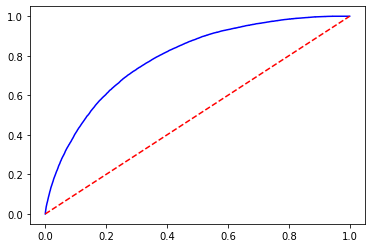

KeyError: 'loan_id'

In [20]:
from sklearn.decomposition import PCA

numerical_col = list(train_df_new.select_dtypes(exclude=['object']).columns)
# category_col = list(filter(lambda x: x not in numerical_col,list(train_df.columns)))
train_df_new[numerical_col] = train_df_new[numerical_col].fillna(train_df_new[numerical_col].median())
# train_df[category_col].fillna(train_df[category_col].mode())


# pca = PCA(n_components=30)
# X_train = train_df_new.drop('isDefault', axis=1)
# X_train = pca.fit_transform(X_train)     
X_train = train_df_new.drop('isDefault', axis=1)
y_train = train_df_new['isDefault']
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(train_x, label=train_y)
valid_matrix = lgb.Dataset(val_x, label=val_y)
params = {
    'boosting_type': 'gbdt',
    'class_weight':'balanced',
            'objective': 'binary',
            'learning_rate': 0.03,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 15,
            'max_depth': 12,
            'reg_lambda': 0.5,
            'reg_alpha': 0.5,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
            'subsample': 0.5
}

model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=1000, verbose_eval=100, early_stopping_rounds=100)


val_pred_lgb = model.predict(val_x, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(val_y, val_pred_lgb)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0,1], 'r--')
plt.show()


# ----------------------------------------------------------------------
# 模型预测
# test_df_new = pca.tranform(test_df_new)
predict = model.predict(test_df_new, num_iteration=model.best_iteration)
# # 生成结果
submission = pd.DataFrame({'id':test_pub['loan_id'], 'isDefault':predict})
# submission.to_csv('submission.csv', index = None)

In [ ]:
import numpy as np  
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, average_precision_score
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

def validation_prediction_lgb(X, y, feature_names, ratio=1, X_test=None, y_test=None, istest=False):
    n_fold = 5
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'metric': 'auc',
        'is_unbalance': False,
        'boost_from_average': False,
    }

    importances = pd.DataFrame()
    if istest:
        prediction = np.zeros(len(X_test))
    models = []
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        weights = [ratio if val == 1 else 1 for val in y_train]
        train_data = lgb.Dataset(X_train, label=y_train, weight=weights)  # free_raw_data=True
        valid_data = lgb.Dataset(X_valid, label=y_valid)
        model = lgb.train(params, train_data, num_boost_round=1000,
                          valid_sets=[train_data, valid_data], verbose_eval=250, early_stopping_rounds=100)
        
        imp_df = pd.DataFrame()
        imp_df['feature'] = feature_names
        imp_df['split'] = model.feature_importance()
        imp_df['gain'] = model.feature_importance(importance_type='gain')
        imp_df['fold'] = fold_n + 1
        importances = pd.concat([importances, imp_df], axis=0)
        models.append(model)
        if istest == True:
            predict_y = model.predict(X_test)
            # 这个地方概率值分档，应该拉出来看看
            predict_label = [1 if i >0.4 else 0 for i in predict_y]
            binary_classifier_metrics(y_test, predict_label, predict_y, False)  # every result
            prediction += predict_y
    if istest == True:
        print('[End]     Average evaluation score: ')
        predict_label = [1 if i >0.4 else 0 for i in prediction/5]  # average result
        binary_classifier_metrics(y_test, predict_label, predict_y)
        sta_bins = segment_statistic(y_test, prediction/5)
        return models, importances, predict_y, sta_bins
    else:
        return models, importances
# 
train_cols = X_train.columns
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
models, importances, prediction, sta_bins = validation_prediction_lgb(train_x, train_y,
                                                            train_cols, X_test=val_x, y_test=val_y, istest=True)

c:\zhangli\software\installer\python38\lib\site-packages\lightgbm\basic.py:1222: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.5 will be ignored. Current value: bagging_fraction=1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.886401
[200]	valid_0's auc: 0.886525
Early stopping, best iteration is:
[133]	valid_0's auc: 0.888062


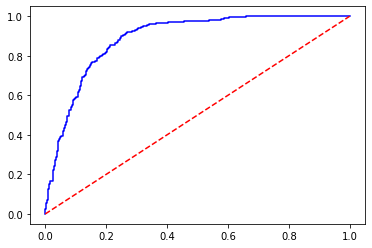

In [28]:
# 建议数据
drop_cols = ['earlies_credit_mon',  'user_id', 'loan_id', ]
common_feature = [col for col in train_pub.columns if col not in drop_cols]

train_pub_new = copy.deepcopy(train_pub)
train_pub_new = train_pub_new[common_feature]

# 特征处理
# -------------------------
train_df_new = preprocessor(train_pub_new)
train_df_new = create_feature(train_df_new)
# ======================================
class_cols = ['class', 'use', 'industry', 'work_year']
mean_cols = ['total_loan', 'monthly_payment', 'interest']
train_df_new = get_mean_std_of_CAC(train_df_new, class_cols, mean_cols)

# -----------------------------------------------------------------------------------------------------------------
common_feature.remove('isDefault')
test_pub_new = copy.deepcopy(test_pub[common_feature])
test_df_new = preprocessor(test_pub_new)
test_df_new = create_feature(test_df_new)
test_df_new = get_mean_std_of_CAC(test_df_new, class_cols, mean_cols)



X_train = train_df_new.drop('isDefault', axis=1)
y_train = train_df_new['isDefault']
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(train_x, label=train_y)
valid_matrix = lgb.Dataset(val_x, label=val_y)
params = {
    'boosting_type': 'gbdt',
    'class_weight':'balanced',
            'objective': 'binary',
            'learning_rate': 0.03,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 15,
            'max_depth': 12,
            'reg_lambda': 0.5,
            'reg_alpha': 0.5,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
            'subsample': 0.5
}

model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=1000, verbose_eval=100, early_stopping_rounds=100)


val_pred_lgb = model.predict(val_x, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(val_y, val_pred_lgb)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0,1], 'r--')
plt.show()


# ----------------------------------------------------------------------
predict = model.predict(test_df_new, num_iteration=model.best_iteration)
# # 生成结果
submission = pd.DataFrame({'id':test_pub['loan_id'], 'isDefault':predict})
submission.to_csv('submission.csv', index = None)